# 🧠 Product Category Classification – Product Title Based ML Model

Ovaj notebook prikazuje kompletan tok rada za razvoj modela masinskog ucenja
koji automatski predlaze kategoriju proizvoda na osnovu njegovog naslova
(*Product Title*).

Cilj:
- Ucitati i analizirati skup podataka `products.csv`
- Pripremiti i ocistiti podatke za modeliranje
- Napraviti smislen **feature engineering** na osnovu naslova proizvoda
- Uporediti vise ML modela za klasifikaciju kategorija
- Izabrati najbolji model, evaluirati ga i sacuvati kao `.pkl` pipeline

Ovaj notebook je oslonac za skriptove:
- `src/train_model.py` – treniranje i cuvanje modela
- `src/predict_category.py` – interaktivno testiranje novog naslova proizvoda


## ⚙️ Uvoz biblioteka i osnovne postavke

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import joblib

# Prikaz svih kolona u DataFrame-u
pd.set_option("display.max_columns", None)

# Stil za grafike
sns.set(style="whitegrid")


## 📚 Ucitavanje podataka

Ucitavamo skup podataka `products.csv` koji se nalazi u folderu `../data/`
u odnosu na ovu radnu svesku (koja je smestena u `notebook/` direktorijumu).


In [2]:
# Putanja do CSV fajla relativno u odnosu na notebook
data_path = os.path.join("..", "data", "products.csv")

df_raw = pd.read_csv(data_path)

print("Dimenzije originalnog skupa:", df_raw.shape)
df_raw.head()


Dimenzije originalnog skupa: (35311, 8)


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


## 🔎 Struktura kolona, tipovi podataka, broj nedostajucih vrednosti

In [3]:
df_raw.info()
print("\nBroj nedostajućih vrednosti po kolonama:")
print(df_raw.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB

Broj nedostajućih vrednosti po kolonama:
product ID           0
Product Title      172
Merchant ID          0
 Category Label     44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
 Listing Date       59
dtype: int64


## 🧹 Priprema i ciscenje podataka

Prvi korak je da standardizujemo nazive kolona (uklanjanje razmaka na pocetku/kraju,
pretvaranje u `snake_case`) i da sredimo osnovna polja:

- fokus je na `Product Title` kao glavnom tekstualnom feature-u,
- `Category Label` je ciljna promenljiva,
- dodatne kolone (`Number_of_Views`, `Merchant Rating`, datum) mozemo koristiti
  kao numeričke feature-e nakon obrade.

U nastavku vrsimo:
- preimenovanje kolona u dosledan format,
- uklanjanje redova sa nedostajucim naslovom ili kategorijom.


In [6]:
# Kopija originalnog DataFrame-a za dalju obradu
df = df_raw.copy()

# Standardizacija naziva kolona
df = df.rename(columns=lambda c: c.strip())  # ukloni leading/trailing razmake
df = df.rename(columns=lambda c: c.lower().replace(" ", "_"))

# Specijalno sredimo naziv kolone za product_code (ako je imala underscore)
if "_product_code" in df.columns:
    df = df.rename(columns={"_product_code": "product_code"})

df.head()





,product_id,product_title,merchant_id,category_label,product_code,number_of_views,merchant_rating,listing_date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


In [8]:
# provera kolona nakon preimenovanja
print("Kolone nakon preimenovanja:")
print(df.columns.tolist())

print("\nBroj nedostajućih vrednosti:")
print(df.isna().sum())


Kolone nakon preimenovanja:
['product_id', 'product_title', 'merchant_id', 'category_label', 'product_code', 'number_of_views', 'merchant_rating', 'listing_date']

Broj nedostajućih vrednosti:
product_id           0
product_title      172
merchant_id          0
category_label      44
product_code        95
number_of_views     14
merchant_rating    170
listing_date        59
dtype: int64


## 🧹 Sve sto nema naslov ili kategoriju – izbacujemo

In [9]:
# Drop redova bez naslova ili kategorije
before_rows = df.shape[0]

df = df.dropna(subset=["product_title", "category_label"])

after_rows = df.shape[0]
print(f"Uklonjeno redova bez naslova ili kategorije: {before_rows - after_rows}")
print("Nove dimenzije skupa:", df.shape)


Uklonjeno redova bez naslova ili kategorije: 215
Nove dimenzije skupa: (35096, 8)


## 🪄 Numericka polja popunjujemo median vrednostima, datume pretvaramo u datetime.

In [10]:
# Popunjavanje numerickih kolona median vrednostima
if "number_of_views" in df.columns:
    df["number_of_views"] = df["number_of_views"].fillna(df["number_of_views"].median())

if "merchant_rating" in df.columns:
    df["merchant_rating"] = df["merchant_rating"].fillna(df["merchant_rating"].median())

# Pretvaranje listing_date u datetime
if "listing_date" in df.columns:
    df["listing_date"] = pd.to_datetime(df["listing_date"], errors="coerce")
    # Nedostajuce datume popunimo najcescim (mode)
    if df["listing_date"].isna().sum() > 0:
        most_common_date = df["listing_date"].mode()[0]
        df["listing_date"] = df["listing_date"].fillna(most_common_date)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 35096 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   product_id       35096 non-null  int64         
 1   product_title    35096 non-null  object        
 2   merchant_id      35096 non-null  int64         
 3   category_label   35096 non-null  object        
 4   product_code     35002 non-null  object        
 5   number_of_views  35096 non-null  float64       
 6   merchant_rating  35096 non-null  float64       
 7   listing_date     35096 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 2.4+ MB


## 🔎 Analiza ciljne promenljive (Category Label)

Pre nego sto predjemo na model, vazno je da razumemo kako su kategorije rasporedjene
(ucesce po klasama). Ovo nam pomaze da vidimo da li postoji jaka neuravnotezenost,
sto moze uticati na izbor modela i metrike.

Broj proizvoda po kategoriji (Top 20):
category_label
Fridge Freezers     5470
Washing Machines    4015
Mobile Phones       4002
CPUs                3747
TVs                 3541
Fridges             3436
Dishwashers         3405
Digital Cameras     2689
Microwaves          2328
Freezers            2201
fridge               123
CPU                   84
Mobile Phone          55
Name: count, dtype: int64


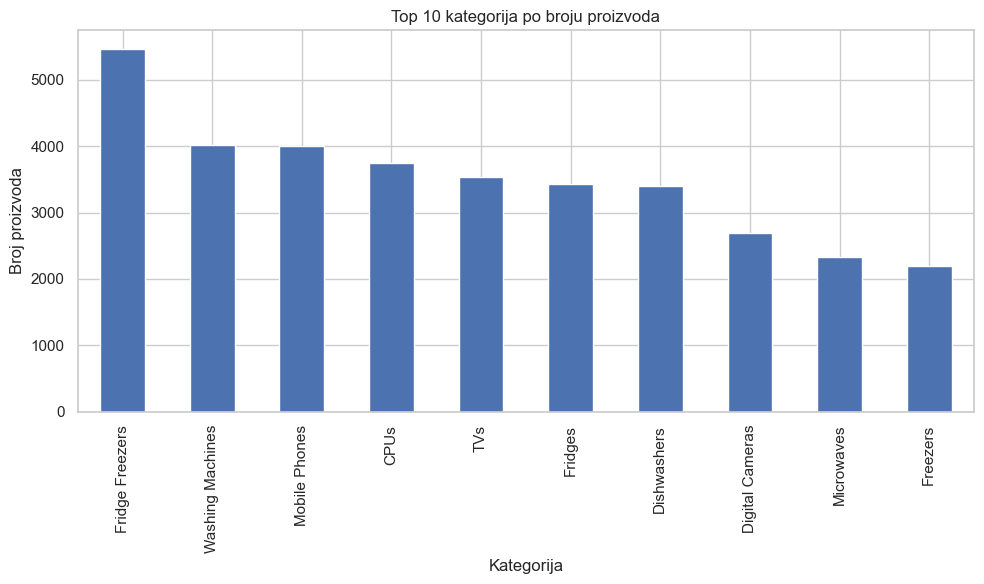

In [11]:
category_counts = df["category_label"].value_counts().sort_values(ascending=False)

print("Broj proizvoda po kategoriji (Top 20):")
print(category_counts.head(20))

plt.figure(figsize=(10, 6))
category_counts.head(10).plot(kind="bar")
plt.title("Top 10 kategorija po broju proizvoda")
plt.xlabel("Kategorija")
plt.ylabel("Broj proizvoda")
plt.tight_layout()
plt.show()


## 📁 Feature engineering

Osnovni ulaz u model je tekstualni naslov proizvoda (`product_title`).

Da bismo modelu dali više informacija, uvodimo dodatne feature-e:

- `title_char_len` – broj karaktera u naslovu,
- `title_word_count` – broj reci u naslovu,
- `title_digit_count` – broj cifara u naslovu,
- `has_digits` – indikator da li naslov sadrzi bar jednu cifru,
- `has_upper_acronym` – indikator prisustva akronima (npr. USB, LED),
- `number_of_views` – (ako postoji) broj pregleda,
- `merchant_rating` – (ako postoji) ocena prodavca.

Ovi feature-i ce biti kombinovani sa TF-IDF reprezentacijom teksta naslova.


In [12]:
# Duzina naslova u karakterima
df["title_char_len"] = df["product_title"].str.len()

# Broj reci u naslovu
df["title_word_count"] = df["product_title"].str.split().str.len()

# Broj cifara u naslovu
df["title_digit_count"] = df["product_title"].str.count(r"\d")

# Da li naslov sadrzi cifru (0/1)
df["has_digits"] = (df["title_digit_count"] > 0).astype(int)

# Da li sadrzi akronim velikim slovima (npr. USB, LED, UHD...)
df["has_upper_acronym"] = df["product_title"].str.contains(r"\b[A-Z]{2,}\b", regex=True).astype(int)

df[["product_title", "title_char_len", "title_word_count", "title_digit_count", "has_digits", "has_upper_acronym"]].head()


,product_title,title_char_len,title_word_count,title_digit_count,has_digits,has_upper_acronym
0,apple iphone 8 plus 64gb silver,31,6,3,1,0
1,apple iphone 8 plus 64 gb spacegrau,35,7,3,1,0
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,70,13,9,1,0
3,apple iphone 8 plus 64gb space grey,35,7,3,1,0
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,54,11,6,1,0
